In [1]:
import matplotlib.pyplot as plt

from scipy.ndimage.interpolation import zoom
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
import numpy as np
import os
import re
from multiprocessing import Process
from scipy import ndimage
import cv2
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.preprocessing import MinMaxScaler

import gradcamutils

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
def load_images(dir_path, H=128, W=128):
    files = os.listdir(dir_path)
    N = len(files)
    X = np.empty((N, H, W, 3))
    for i, file in tqdm(enumerate(files)):
        x = cv2.imread(dir_path + file)
        x = cv2.resize(x, (H,W))
        x = x/np.max(x)
        X[i] = x
    top = np.argmax(model.predict(X), axis=1)
    
    return X, top

def get_saliency_maps(model, X, top, H=128, W=128, batch_size=256, layer='conv2d_13'):
    gradcam = np.empty((X.shape[0], H, W))
    N = len(X)
    for i in tqdm(range((N + batch_size - 1) // batch_size)):
        start = i * batch_size
        end = min((i+1) * batch_size, N)
        gradcam[start:end] = gradcamutils.grad_cam_batch(model, X[start:end], top[start:end], layer, H, W)
    
    return gradcam

def get_guided_backprop_vals(guided_model, X, layer='conv2d_13'):
    gbp = np.empty((X.shape))
    batch_size = 300
    N = len(X)
    for i in tqdm(range((N + batch_size - 1) // batch_size)):
        start = i * batch_size
        end = min((i+1) * batch_size, N)
        gbp[start:end] = gradcamutils.guided_backprop(guided_model, X[start:end], layer)
        
    return gbp

def get_bp_from_gbp(gbp, pos, kernel):
    i, j = kernel
    bp = []
    for p in pos:
        x = p[0]
        y = p[1]
        
        alpha_w = gbp[x-i//2:x+i//2, y-j//2:y+j//2, 0]
        beta_w = gbp[x-i//2:x+i//2, y-j//2:y+j//2, 1]
        gamma_w = gbp[x-i//2:x+i//2, y-j//2:y+j//2, 2]
        
        alpha = np.median(alpha_w)
        beta = np.median(beta_w)
        gamma = np.median(gamma_w)
        
        bp.extend([alpha, beta, gamma])
        
    return bp

def show_kernel_ch_pos(pos, kernel, gbp):
    topo = cv2.imread("r_64_ch_topomap.png", cv2.IMREAD_COLOR)
    topo = cv2.resize(topo, (128,128))
#     topo = np.zeros((128,128), np.uint8)
    m,n = kernel
#     for p in pos:
#         x = p[0]
#         y = p[1]

#         topo[x,y] = 255
#         topo[x-m//2:x+n//2, y-m//2:y+n//2] = 175
        
    fig, ax = plt.subplots(1)

    ax.imshow(topo)
    gbp = gradcamutils.deprocess_image(gbp)
    ax.imshow(gbp, cmap='jet', alpha=0.5)
    

    for p in pos:
        x = p[0]
        y = p[1]
        b_box = patches.Rectangle([y-m//4,x-n//4], m//2, n//2, facecolor='none', edgecolor='r', linewidth=1)
        ax.add_patch(b_box)

    plt.show()
def scale_img(img, qmin=0, qmax=255):
    max_val = img.max()
    min_val = img.min()
    scaled_img = ((img - min_val)/(max_val - min_val)) * (qmax - qmin)
    
    return scaled_img.astype(np.uint8)
def normalize(img):
    img = img.astype(np.float64)
    max_val = img.max()
    min_val = img.min()
    img = (img - min_val)/(max_val - min_val)
    return img
        
def visualize(sm):
    x = cv2.imread("r_64_ch_topomap.png")
    x = cv2.resize(x, (128,128))
    sm = gradcamutils.deprocess_image(sm)
#     sm = scale_img(sm)

    plt.imshow(x)
    plt.imshow(sm, cmap='jet', alpha=0.5)
#     plt.colorbar()
#     plt.show()
    plt.savefig("kernel_ggbp.png")

In [3]:
model = load_model('top_10_spsm/SPSM-10.h5')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 67) 1876        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 67) 268         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 67)   0           batch_normalization[0][0]        
_____________

In [4]:
g_model = gradcamutils.build_guided_model(model)

In [5]:
def find_rel_layer(model):
    rel_layer = None
    for layer in model.layers[::-1]:
        
        if 'add' in layer.name or 'conv2d' in layer.name:
            rel_layer = layer.name
            break
            
    return rel_layer

In [6]:
find_rel_layer(g_model)

'add_7'

In [4]:
slow_path = 'data/topomaps_RT_50_w_sub_h1/test/combined/0/'
med_path = 'data/topomaps_RT_50_w_sub_h1/test/combined/3/'
fast_path = 'data/topomaps_RT_50_w_sub_h1/test/combined/1/'

topo_slow, Y_slow = load_images(slow_path)
topo_med, Y_med = load_images(med_path)
topo_fast, Y_fast = load_images(fast_path)

In [5]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            31G         12G        279M        1.6G         18G         16G
Swap:          2.0G        1.3G        751M


In [5]:
sm_slow = get_saliency_maps(model, topo_slow, Y_slow, batch_size=500, layer='conv2d_5')
sm_med = get_saliency_maps(model, topo_med, Y_med, batch_size=500, layer='conv2d_5')
sm_fast = get_saliency_maps(model, topo_fast, Y_fast, batch_size=500, layer='conv2d_5')

np.save("sm_slow_h1.npy", sm_slow)
np.save("sm_med_h1.npy", sm_med)
np.save("sm_fast_h1.npy", sm_fast)

(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(245, 32, 32, 144) (245, 144) (245, 32, 32)



(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(165, 32, 32, 144) (165, 144) (165, 32, 32)



(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(500, 32, 32, 144) (500, 144) (500, 32, 32)
(222, 32, 32, 144) (222, 144) (222, 32, 32)



In [5]:
guided_model = gradcamutils.build_guided_model(model)

In [6]:
# gbp_slow = get_guided_backprop_vals(guided_model, topo_slow, layer='conv2d_5')
# np.save("gbp_slow_h1", gbp_slow)
# del gbp_slow

# gbp_med = get_guided_backprop_vals(guided_model, topo_med, layer='conv2d_5')
# np.save("gbp_med_h1", gbp_med)
# del gbp_med

gbp_fast = get_guided_backprop_vals(guided_model, topo_fast, layer='conv2d_5')
np.save("gbp_fast_h1", gbp_fast)
del gbp_fast

In [3]:
gbp_slow = np.load("gbp_slow_h1.npy")
gbp_med = np.load("gbp_med_h1.npy")
gbp_fast = np.load("gbp_fast_h1.npy")

sm_slow = np.load("sm_slow_h1.npy")
sm_med = np.load("sm_med_h1.npy")
sm_fast = np.load("sm_fast_h1.npy")

guided_grad_slow = gbp_slow * sm_slow[..., np.newaxis]
guided_grad_med = gbp_med * sm_med[..., np.newaxis]
guided_grad_fast = gbp_fast * sm_fast[..., np.newaxis]

In [4]:
guided_grad_slow = np.where(guided_grad_slow < 0, 0, guided_grad_slow)
guided_grad_med = np.where(guided_grad_med < 0, 0, guided_grad_med)
guided_grad_fast = np.where(guided_grad_fast < 0, 0, guided_grad_fast)

np.save("guided_grad_slow_h1.npy", guided_grad_slow)
np.save("guided_grad_med_h1.npy", guided_grad_med)
np.save("guided_grad_fast_h1.npy", guided_grad_fast)

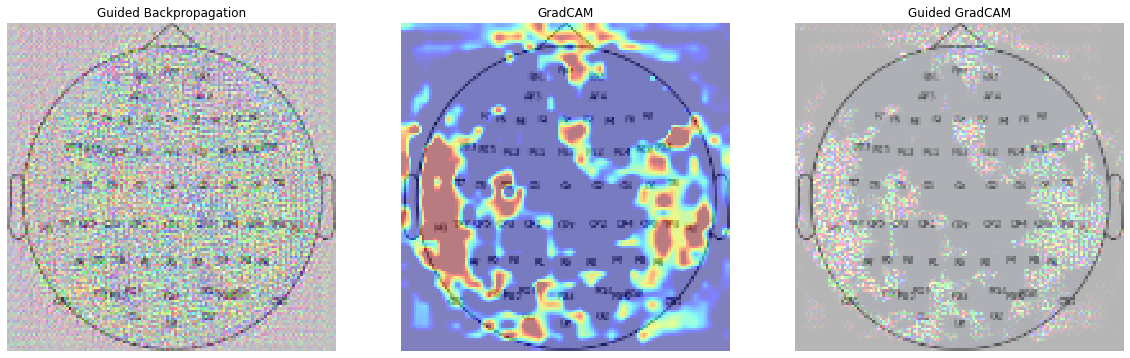

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.axis("off")
plt.title("Guided Backpropagation")
visualize(gbp_slow[1])

plt.subplot(132)
plt.axis("off")
plt.title("GradCAM")
visualize(sm_slow[1])

plt.subplot(133)
plt.axis("off")
plt.title("Guided GradCAM")
visualize(guided_grad_slow[1])

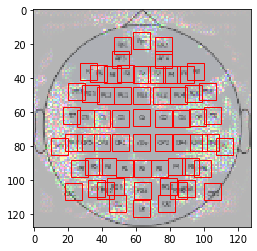

In [7]:
pos = np.load("channel_pos_128x128.npy")

show_kernel_ch_pos(pos, (20,20), guided_grad_slow[1])

In [8]:
bps_slow = np.zeros((len(guided_grad_slow), 192))
bps_fast = np.zeros((len(guided_grad_fast), 192))
bps_med = np.zeros((len(guided_grad_med), 192))

for i, g_cam in tqdm(enumerate(guided_grad_slow)):
    bps_slow[i] = get_bp_from_gbp(g_cam, pos, (10,10))
    
for i, g_cam in tqdm(enumerate(guided_grad_fast)):
    bps_fast[i] = get_bp_from_gbp(g_cam, pos, (10,10))

for i, g_cam in tqdm(enumerate(guided_grad_med)):
    bps_med[i] = get_bp_from_gbp(g_cam, pos, (10,10))
    
    
np.save("bps_slow_n_10_10_h1.npy", bps_slow)
np.save("bps_fast_n_10_10_h1.npy", bps_fast)
np.save("bps_med_n_10_10_h1.npy", bps_med)

In [9]:
bps_slow = np.zeros((len(guided_grad_slow), 192))
bps_fast = np.zeros((len(guided_grad_fast), 192))
bps_med = np.zeros((len(guided_grad_med), 192))

for i, g_cam in tqdm(enumerate(guided_grad_slow)):
    bps_slow[i] = get_bp_from_gbp(g_cam, pos, (20,20))
    
for i, g_cam in tqdm(enumerate(guided_grad_fast)):
    bps_fast[i] = get_bp_from_gbp(g_cam, pos, (20,20))

for i, g_cam in tqdm(enumerate(guided_grad_med)):
    bps_med[i] = get_bp_from_gbp(g_cam, pos, (20,20))
    
    
np.save("bps_slow_n_20_20_h1.npy", bps_slow)
np.save("bps_fast_n_20_20_h1.npy", bps_fast)
np.save("bps_med_n_20_20_h1.npy", bps_med)